In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import torch


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "SPY.csv"
df = pd.read_csv(file_path)




# start to nov 2001 (dot com crash)
# not bad
# df = df.iloc[:2228]

# nov 01 to june 2009
# not bad
# df = df.iloc[2228:4135]

# june 2009 to april 2020
# ass
df = df.iloc[4135:6862]

# april 2020 to most recent
# ass
# df = df.iloc[6862:]


# Convert the "Date" column to datetime
# df["Date"] = pd.to_datetime(df["Date"], format='%Y/%m/%d')

# # Sort the data by date in ascending order
# df = df.sort_values(by="Date")

# # Get the earliest and latest dates
# earliest_date = df["Date"].min()
# latest_date = df["Date"].max()

# print("Earliest Date:", earliest_date)
# print("Latest Date:", latest_date)


In [4]:
print(df.tail())

            Date        Open        High         Low       Close     Volume  \
6857  2020-04-23  262.458644  265.686871  260.830509  261.139282  104709700   
6858  2020-04-24  262.683183  265.462257  260.596529  264.779175   85063200   
6859  2020-04-27  266.791031  269.738528  266.323174  268.596954   77896600   
6860  2020-04-28  272.311790  272.667366  267.053075  267.361877  105270000   
6861  2020-04-29  272.788998  275.923649  271.741002  274.360992  118745600   

      Day  Weekday  Week  Month  Year  
6857   23        3    17      4  2020  
6858   24        4    17      4  2020  
6859   27        0    18      4  2020  
6860   28        1    18      4  2020  
6861   29        2    18      4  2020  


In [5]:
# if 'Day' and 'Weekday' and 'Week' and 'Month' and 'Year' in df.columns:
    # df.drop(columns=['Day', 'Weekday', 'Week', 'Month', 'Year'], inplace=True)

In [6]:
if "Target" not in df.columns:
    # df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
    df["Target"] = df["Close"].shift(-1)


In [7]:
df = df.dropna()

In [8]:
# Adding SMA as part of the feature test
short_term_period = 20
medium_term_period = 50
long_term_period = 200

# Compute the SMAs
df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
df['SMA_200'] = df['Close'].rolling(window=long_term_period).mean()

df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()  # Short-term EMA
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()  # Medium-term EMA
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()  # Long-term EMA


<ipython-input-8-74f4df1ad5d0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_20'] = df['Close'].rolling(window=short_term_period).mean()
<ipython-input-8-74f4df1ad5d0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['SMA_50'] = df['Close'].rolling(window=medium_term_period).mean()
<ipython-input-8-74f4df1ad5d0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [9]:
df = df.dropna()

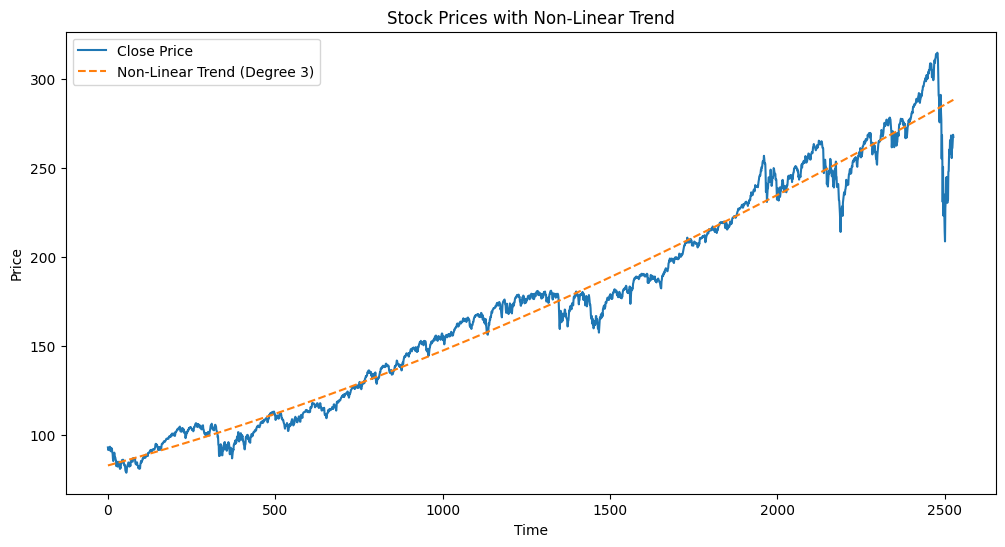

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Assuming you have a DataFrame `df` with a 'Close' column

# Create an index for the time series (usually the row number)
df['Time'] = np.arange(len(df))

# Fit a polynomial regression to the 'Close' price
X = df[['Time']]  # Independent variable (time)
y = df['Close']   # Dependent variable (closing price)

# Initialize a polynomial features transformer (degree = 2 for quadratic, or higher for more non-linearity)
degree = 3  # You can change the degree for more complexity
poly = PolynomialFeatures(degree)

# Transform the Time feature into polynomial features
X_poly = poly.fit_transform(X)

# Initialize and fit the linear regression model to the polynomial features
model = LinearRegression()
model.fit(X_poly, y)

# Generate predictions for the polynomial regression (non-linear trend)
df['Non_Linear_Trend'] = model.predict(X_poly)

# Optionally, visualize the non-linear trend
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Close'], label='Close Price')
plt.plot(df['Time'], df['Non_Linear_Trend'], label=f'Non-Linear Trend (Degree {degree})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Prices with Non-Linear Trend')
plt.legend()
plt.show()

## CREATING THE NEURAL NETWORK MODEL

In [11]:
dates = df["Date"]
X = df.drop(columns=["Date", "Target"])
y = df["Target"]

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [13]:
# Define the LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)
        out = self.fc(out)  # Shape: (batch_size, 1)
        out = self.sigmoid(out)
        return out

# Define a more complex LSTM-based model
# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         out = self.sigmoid(out)  # Apply sigmoid for binary classification
#         return out

# class ComplexLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
#         super(ComplexLSTMModel, self).__init__()
#         # LSTM Layer: Bidirectional for richer context
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
#                             batch_first=True, dropout=dropout_rate,
#                             bidirectional=True)
#         # Fully connected layers for added complexity
#         self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Bidirectional LSTM doubles hidden size
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc3 = nn.Linear(hidden_size // 2, 1)

#     def forward(self, x):
#         # LSTM expects input of shape (batch_size, sequence_length, input_size)
#         out, _ = self.lstm(x)
#         # Use the output of the last time step
#         out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
#         out = self.fc1(out)  # First fully connected layer
#         out = self.dropout1(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc2(out)  # Second fully connected layer
#         out = self.dropout2(out)
#         out = torch.relu(out)  # Nonlinear activation
#         out = self.fc3(out)  # Output layer
#         return out

class ComplexLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(ComplexLSTMModel, self).__init__()
        # Unidirectional LSTM for sequential stock price prediction
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)  # Removed bidirectional=True

        # Fully connected layers for added complexity
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size // 4, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, input_size)
        out, _ = self.lstm(x)
        # Use the output of the last time step
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        out = torch.relu(self.fc1(out))  # First fully connected layer
        out = self.dropout1(out)
        out = torch.relu(self.fc2(out))  # Second fully connected layer
        out = self.dropout2(out)
        out = self.fc3(out)  # Output layer (no activation for regression)
        return out


In [14]:

sequence_length = 10

# Reshape data into sequences
def create_sequences(data, target, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i + seq_length])
        y_seq.append(target[i + seq_length])
    return np.array(X_seq), np.array(y_seq)


In [15]:

# scaler = StandardScaler()
# scaler = MinMaxScaler()
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Day", "Weekday", "Week", "Month", "Year"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200", "Non_Linear_Trend"]
feature_columns = ["Open", "High", "Low", "Close", "Volume", "SMA_20", "SMA_50", "SMA_200", "EMA_10", "EMA_50", "EMA_200"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend", "SMA_20", "SMA_50", "EMA_10", "EMA_50"]
# feature_columns = ["Open", "High", "Low", "Close", "Volume", "Non_Linear_Trend"]

# Split data
train_size = int(X.shape[0] * 0.7)
val_size = int(X.shape[0] * 0.15)

# Initialize scaler
# scaler = RobustScaler()
scaler = MinMaxScaler()

# Split data into train, validation, and test
temp_train = X[:train_size]
temp_val = X[train_size:train_size + val_size]
temp_test = X[train_size + val_size:]

temp_train = temp_train[feature_columns]
temp_val = temp_val[feature_columns]
temp_test = temp_test[feature_columns]

# Fit and transform for train, transform for validation and test
temp_train = scaler.fit_transform(temp_train)
temp_val = scaler.transform(temp_val)
temp_test = scaler.transform(temp_test)

# Convert NumPy arrays back to DataFrames
temp_train = pd.DataFrame(temp_train, columns=feature_columns)
temp_val = pd.DataFrame(temp_val, columns=feature_columns)
temp_test = pd.DataFrame(temp_test, columns=feature_columns)

# Concatenate the data
X_scaled = pd.concat([temp_train, temp_val, temp_test], axis=0)

# scaler = StandardScaler()

# scaler.fit(X_train)
# X_scaled = pd.DataFrame(scaler.fit_transform(X[feature_columns]), columns=feature_columns, index=X.index)

X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)


# Split sequentially
X_train, y_train = X_seq[:train_size], y_seq[:train_size]
X_val, y_val = X_seq[train_size:train_size + val_size], y_seq[train_size:train_size + val_size]
X_test, y_test = X_seq[train_size + val_size:], y_seq[train_size + val_size:]

# Print sizes to confirm
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 1768, Val: 379, Test: 370


In [16]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [17]:
# THE OG
# Hyperparameters
# input_size = X_train.shape[2]  # Number of features
# hidden_size = 32
# num_layers = 2
# dropout_rate = 0.3
# learning_rate = 0.01
# num_epochs = 100
# patience = 17

# Hyperparameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 4
dropout_rate = 0.3
learning_rate = 0.0001
num_epochs = 500
patience = 30


# Initialize the LSTM model
# model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

model.to(device)

# Define loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
best_val_loss = float('inf')
early_stop_counter = 0

# if not os.path.exists("./models/best_lstm_model.pth"):
if not os.path.exists("./lstm_trials/lstm_after_gridsearch_new.pth"):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_batch = y_batch.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_batch = y_batch.unsqueeze(1)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), "./lstm_trials/lstm_after_gridsearch_new.pth")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

# Load the best model
# model.load_state_dict(torch.load("./lstm_trials/lstm_after_gridsearch_new.pth"))

# Evaluate on test data
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item() * X_batch.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

# Calculate Mean Absolute Error (MAE)
test_mae = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        mae = torch.mean(torch.abs(outputs - y_batch))
        test_mae += mae.item() * X_batch.size(0)

test_mae /= len(test_loader.dataset)
print(f'Test MAE: {test_mae:.4f}')


Epoch 1/500, Train Loss: 21294.6328, Val Loss: 56740.1875
Epoch 2/500, Train Loss: 21290.7078, Val Loss: 56669.1348
Epoch 3/500, Train Loss: 21265.8813, Val Loss: 56407.1198
Epoch 4/500, Train Loss: 21065.3441, Val Loss: 56109.1243
Epoch 5/500, Train Loss: 20829.4454, Val Loss: 55782.4440
Epoch 6/500, Train Loss: 20675.5925, Val Loss: 55434.2357
Epoch 7/500, Train Loss: 20439.5490, Val Loss: 55030.1803
Epoch 8/500, Train Loss: 20254.2636, Val Loss: 54574.8581
Epoch 9/500, Train Loss: 19893.8295, Val Loss: 54070.3841
Epoch 10/500, Train Loss: 19631.1790, Val Loss: 53510.4740
Epoch 11/500, Train Loss: 19284.7691, Val Loss: 52894.4017
Epoch 12/500, Train Loss: 18911.9587, Val Loss: 52216.6673
Epoch 13/500, Train Loss: 18509.0407, Val Loss: 51451.5013
Epoch 14/500, Train Loss: 18058.9945, Val Loss: 50626.2090
Epoch 15/500, Train Loss: 17536.3180, Val Loss: 49736.8711
Epoch 16/500, Train Loss: 17057.9613, Val Loss: 48780.3346
Epoch 17/500, Train Loss: 16450.8417, Val Loss: 47760.7878
Epoch 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MAE: 62.7993


In [18]:
# Evaluate the model
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred_binary))

# # Generate precision, recall, and F1-score
# print("\nClassification Report:")
# print(classification_report(y_test, y_pred_binary, target_names=["Class 0", "Class 1"]))


In [19]:
X_seq_tensor = torch.tensor(X_seq, dtype=torch.float32).to(device)
y_seq_tensor = torch.tensor(y_seq, dtype=torch.float32).to(device)

outputs = model(X_seq_tensor)


In [20]:
error = 0
largest_error = 0
less_than_actual = 0
more_than_actual = 0

for true, pred in zip(y_seq, outputs):
    percent = abs(true - pred) / true
    if percent > largest_error:
        largest_error = percent
    error += percent
    if pred < true:
        less_than_actual += 1
    else:
        more_than_actual += 1

error = error / len(y_seq)
error = error.item()
largest_error = largest_error.item()
print(f"Average error percentage: {error*100}")
print(f"Largest error percentage: {largest_error*100}")
print(f"Less than actual: {less_than_actual}")
print(f"More than actual: {more_than_actual}")


Average error percentage: 9.559045732021332
Largest error percentage: 34.843191504478455
Less than actual: 2470
More than actual: 47


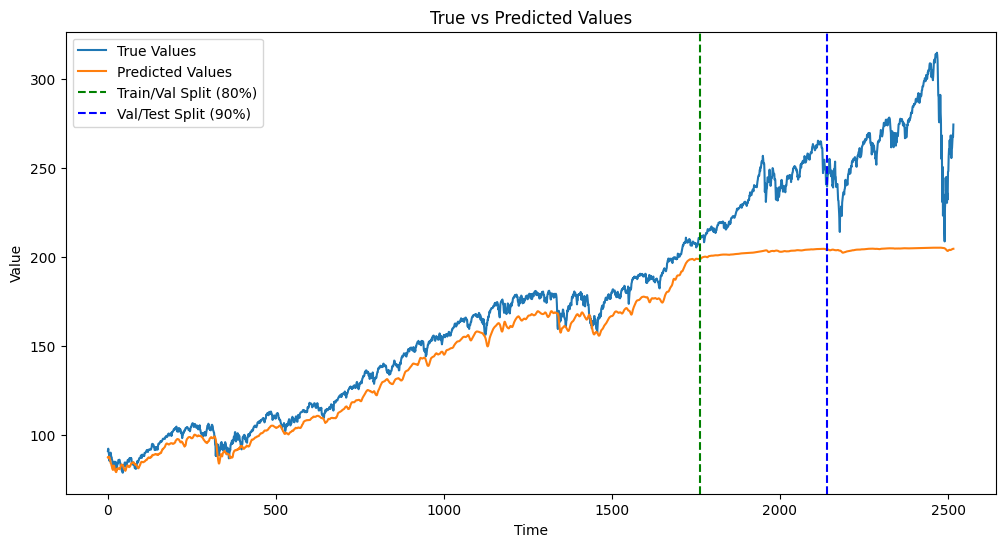

In [21]:
train_cutoff = int(len(y_seq) * 0.7)
val_cutoff = int(len(y_seq) * 0.85)

plt.figure(figsize=(12, 6))
plt.plot(y_seq, label='True Values')
plt.plot(outputs.cpu().detach().numpy(), label='Predicted Values')
plt.axvline(x=train_cutoff, color='g', linestyle='--', label='Train/Val Split (80%)')
plt.axvline(x=val_cutoff, color='b', linestyle='--', label='Val/Test Split (90%)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

In [22]:
outputs

tensor([[ 87.1343],
        [ 86.8101],
        [ 87.4479],
        ...,
        [204.4174],
        [204.4518],
        [204.4752]], grad_fn=<AddmmBackward0>)

In [23]:
df['Target_Higher_Lower'] = np.where(df['Target'] > df['Open'], 'higher', 'lower')

In [24]:
# Ensure outputs is detached from the computation graph and converted to numpy
predicted_values = outputs.cpu().detach().numpy()

# Add the predicted values as a new column in the dataframe
df['Predicted'] = np.nan
df.loc[df.index[-len(predicted_values):], 'Predicted'] = predicted_values

print(df[['Date', 'Target', 'Predicted']].tail())

            Date      Target   Predicted
6856  2020-04-22  261.139282  204.289917
6857  2020-04-23  264.779175  204.362839
6858  2020-04-24  268.596954  204.417389
6859  2020-04-27  267.361877  204.451813
6860  2020-04-28  274.360992  204.475204


In [25]:
new_df = df.dropna()

In [26]:
new_df['Predicted_Higher_Lower'] = np.where(new_df['Predicted'] > new_df['Open'], 'higher', 'lower')
new_df['Correct'] = np.where(new_df['Predicted_Higher_Lower'] == new_df['Target_Higher_Lower'], 1, 0)

print('number of correct predictions:', new_df['Correct'].sum())

number of correct predictions: 1104


<ipython-input-26-54f40e89f447>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Predicted_Higher_Lower'] = np.where(new_df['Predicted'] > new_df['Open'], 'higher', 'lower')
<ipython-input-26-54f40e89f447>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Correct'] = np.where(new_df['Predicted_Higher_Lower'] == new_df['Target_Higher_Lower'], 1, 0)


In [27]:
# # train model 10 times and get results with prediction error, max error etc
# error_array = []
# largest_error_array = []
# for i in range (10):
#     model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)

#     # Define loss and optimizer
#     # criterion = nn.BCELoss()
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#     # Training loop with early stopping
#     best_val_loss = float('inf')
#     early_stop_counter = 0

#     # if not os.path.exists("./models/best_lstm_model.pth"):
#     if not os.path.exists("./lstm_trials/lstm.pth"):
#         for epoch in range(num_epochs):
#             model.train()
#             train_loss = 0
#             for X_batch, y_batch in train_loader:
#                 y_batch = y_batch.unsqueeze(1)  # Match output shape
#                 optimizer.zero_grad()
#                 outputs = model(X_batch)
#                 loss = criterion(outputs, y_batch)
#                 loss.backward()
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#                 optimizer.step()
#                 train_loss += loss.item()

#             train_loss /= len(train_loader)

#             # Validation
#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for X_batch, y_batch in val_loader:
#                     y_batch = y_batch.unsqueeze(1)
#                     outputs = model(X_batch)
#                     loss = criterion(outputs, y_batch)
#                     val_loss += loss.item()

#             val_loss /= len(val_loader)
#             print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


#             # Early stopping
#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 # torch.save(model.state_dict(), "./lstm_trials/lstm_5.pth")
#                 early_stop_counter = 0
#             else:
#                 early_stop_counter += 1
#                 print(f"Early stopping counter: {early_stop_counter}/{patience}")
#                 if early_stop_counter >= patience:
#                     print("Early stopping triggered.")
#                     break
#     model.eval()
#     test_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             outputs = model(X_batch)
#             loss = criterion(outputs, y_batch)
#             test_loss += loss.item() * X_batch.size(0)

#     test_loss /= len(test_loader.dataset)
#     print(f'Test Loss: {test_loss:.4f}')

#     # Calculate Mean Absolute Error (MAE)
#     test_mae = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in test_loader:
#             outputs = model(X_batch)
#             mae = torch.mean(torch.abs(outputs - y_batch))
#             test_mae += mae.item() * X_batch.size(0)

#     test_mae /= len(test_loader.dataset)
#     print(f'Test MAE: {test_mae:.4f}')

#     outputs = model(X_seq_tensor)
#     error = 0
#     largest_error = 0
#     less_than_actual = 0
#     more_than_actual = 0

#     for true, pred in zip(y_seq, outputs):
#         percent = abs(true - pred) / true
#         if percent > largest_error:
#             largest_error = percent
#         error += percent
#         if pred < true:
#             less_than_actual += 1
#         else:
#             more_than_actual += 1

#     error = error / len(y_seq)
#     error = error.item()
#     largest_error = largest_error.item()
#     # print(f"Average error percentage: {error*100}")
#     # print(f"Largest error percentage: {largest_error*100}")
#     # print(f"Less than actual: {less_than_actual}")
#     # print(f"More than actual: {more_than_actual}")
#     error_array.append(error*100)
#     largest_error_array.append(largest_error*100)

# print('Average error percentage:', np.mean(error_array))
# print('Average largest error percentage:', np.mean(largest_error_array))
# print("Standard deviation of average error percentage:", np.std(error_array))
# print("Standard deviation of average largest error percentage:", np.std(largest_error_array))


In [28]:
X_seq_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_seq_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

outputs = model(X_seq_tensor)


In [29]:
error = 0
largest_error = 0
less_than_actual = 0
more_than_actual = 0

for true, pred in zip(y_test, outputs):
    percent = abs(true - pred) / true
    if percent > largest_error:
        largest_error = percent
    error += percent
    if pred < true:
        less_than_actual += 1
    else:
        more_than_actual += 1

error = error / len(y_test)
error = error.item()
largest_error = largest_error.item()
print(f"Average error percentage: {error*100}")
print(f"Largest error percentage: {largest_error*100}")
print(f"Less than actual: {less_than_actual}")
print(f"More than actual: {more_than_actual}")


Average error percentage: 23.012597858905792
Largest error percentage: 34.843191504478455
Less than actual: 370
More than actual: 0


In [30]:
import itertools
import torch

# Define possible hyperparameter ranges
hidden_sizes = [64, 128]
num_layers_list = [2, 3, 4]
dropout_rates = [0.1, 0.3, 0.5]
learning_rates = [0.001, 0.0005, 0.0001]
patience_values = [30]
num_repeats = 5  # Number of times each combination is trained


# Generate all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(hidden_sizes, num_layers_list, dropout_rates, learning_rates, patience_values))

# Initialize best loss
best_avg_loss = float('inf')
best_model = None
best_params = None

# Counter
total_count = len(hyperparameter_combinations)
current_count = 0

# Loop over all combinations
for hidden_size, num_layers, dropout_rate, learning_rate, patience in hyperparameter_combinations:
    print(f"Training with hidden_size={hidden_size}, num_layers={num_layers}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, patience={patience}")
    print(f"Progress: {current_count}/{total_count}")
    current_count += 1

    total_val_loss = 0  # Accumulator for validation losses

    for repeat in range(num_repeats):
        print(f"  Repeat {repeat + 1}/{num_repeats}")

        # Reinitialize the model
        model = ComplexLSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, dropout_rate=dropout_rate)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        best_loss = float('inf')
        epoch_no_improve = 0  # Counter for early stopping

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            train_loss = 0
            for X_batch, y_batch in train_loader:
                y_batch = y_batch.unsqueeze(1)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)

            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    y_batch = y_batch.unsqueeze(1)
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            print(f"    Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                epoch_no_improve = 0  # Reset counter
            else:
                epoch_no_improve += 1
                print(f"    Early stopping counter: {epoch_no_improve}/{patience}")
                if epoch_no_improve >= patience:
                    print("    Early stopping triggered.")
                    break

        total_val_loss += best_loss  # Add the best validation loss from this repeat

    # Compute the average validation loss across `num_repeats` runs
    avg_val_loss = total_val_loss / num_repeats
    print(f"Average Validation Loss for this combination: {avg_val_loss:.4f}")

    # Check if this is the best combination so far
    if avg_val_loss < best_avg_loss:
        best_avg_loss = avg_val_loss
        best_model = model.state_dict()
        best_params = (hidden_size, num_layers, dropout_rate, learning_rate, patience)

# Load the best model
model.load_state_dict(best_model)
print(f"Best model parameters: {best_params}")


Streaming output truncated to the last 5000 lines.
    Epoch 60/500, Train Loss: 819.6480, Val Loss: 1596.8066
    Early stopping counter: 9/30
    Epoch 61/500, Train Loss: 772.4784, Val Loss: 1231.8726
    Early stopping counter: 10/30
    Epoch 62/500, Train Loss: 835.1001, Val Loss: 1376.9017
    Early stopping counter: 11/30
    Epoch 63/500, Train Loss: 829.4606, Val Loss: 1505.2469
    Early stopping counter: 12/30
    Epoch 64/500, Train Loss: 771.2870, Val Loss: 1469.2346
    Early stopping counter: 13/30
    Epoch 65/500, Train Loss: 760.3759, Val Loss: 1408.2328
    Early stopping counter: 14/30
    Epoch 66/500, Train Loss: 763.9076, Val Loss: 1406.5674
    Early stopping counter: 15/30
    Epoch 67/500, Train Loss: 789.8200, Val Loss: 1542.8239
    Early stopping counter: 16/30
    Epoch 68/500, Train Loss: 826.5560, Val Loss: 1484.7035
    Early stopping counter: 17/30
    Epoch 69/500, Train Loss: 762.5198, Val Loss: 1328.2929
    Early stopping counter: 18/30
    Epoch 

RuntimeError: Error(s) in loading state_dict for ComplexLSTMModel:
	Missing key(s) in state_dict: "lstm.weight_ih_l2", "lstm.weight_hh_l2", "lstm.bias_ih_l2", "lstm.bias_hh_l2", "lstm.weight_ih_l3", "lstm.weight_hh_l3", "lstm.bias_ih_l3", "lstm.bias_hh_l3". 

In [31]:
best_params

(128, 2, 0.1, 0.0005, 30)

In [32]:
print("Best params at hidden size 128, 2 layers, dropout rate 0.1, learning rate 0.0005, patience 30")

Best params at hidden size 128, 2 layers, dropout rate 0.1, learning rate 0.0005, patience 30
